In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Paths of the folders containing the images
clean_covid_folder = 'dataset/clean_images/COVID'
clean_lung_opacity_folder = 'dataset/clean_images/Lung_Opacity'
clean_normal_folder = 'dataset/clean_images/Normal'
clean_viral_pneumonia_folder = 'dataset/clean_images/Viral_Pneumonia'
clean_folders = [clean_covid_folder, clean_lung_opacity_folder, clean_normal_folder, clean_viral_pneumonia_folder]

# Resized image directories
resized_covid_folder = 'dataset/resized_images/COVID'
resized_lung_opacity_folder = 'dataset/resized_images/Lung_Opacity'
resized_normal_folder = 'dataset/resized_images/Normal'
resized_viral_pneumonia_folder = 'dataset/resized_images/Viral_Pneumonia'
resized_folders = [resized_covid_folder, resized_lung_opacity_folder, resized_normal_folder, resized_viral_pneumonia_folder]

# Directories to save the standardized images
standardized_covid_folder = 'dataset/standardized_images/COVID'
standardized_lung_opacity_folder = 'dataset/standardized_images/Lung_Opacity'
standardized_normal_folder = 'dataset/standardized_images/Normal'
standardized_viral_pneumonia_folder = 'dataset/standardized_images/Viral_Pneumonia'
standardized_folders = [standardized_covid_folder, standardized_lung_opacity_folder, standardized_normal_folder, standardized_viral_pneumonia_folder]

# Directories to save the featured images
featured_covid_folder = 'dataset/featured_images/COVID'
featured_lung_opacity_folder = 'dataset/featured_images/Lung_Opacity'
featured_normal_folder = 'dataset/featured_images/Normal'
featured_viral_pneumonia_folder = 'dataset/featured_images/Viral_Pneumonia'
featured_folders = [featured_covid_folder, featured_lung_opacity_folder, featured_normal_folder, featured_viral_pneumonia_folder]


In [5]:
# Load the images of the folder with its label
def load_data(image_folder, label):
    data = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            tensor = tf.convert_to_tensor(img)
            data.append([tensor, label])
    return data

# Shows information of folders and the images
def info(folders, img):
    print("Image dimensions:", img.shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    counts = [len(os.listdir(folder)) for folder in folders]
    class_labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
    data = {'Class': class_labels, 'Count': counts}
    df = pd.DataFrame(data).style.hide()
    
    print("Number of images per class")
    return df
    
# Create directories if it doesn't exist
def create_directories(folders):
    for folder in folders:
        os.makedirs(folder, exist_ok=True)

# 1. DATA ANALYSIS

Image dimensions: (299, 299)


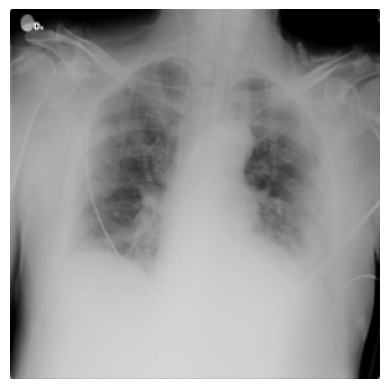

Number of images per class


Class,Count
COVID,3616
Lung Opacity,6012
Normal,10192
Viral Pneumonia,1345


In [6]:
# Show information
image = cv2.imread(clean_covid_folder+'/COVID-1.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=clean_folders, img=image)
df

# 2. FEATURE ENGINEERING

Se toma una cantidad especifica de cada conjunto para que haya una similitud entre todos los conjuntos y se redimensionan a 128x128 

STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.
Image dimensions: (128, 128)


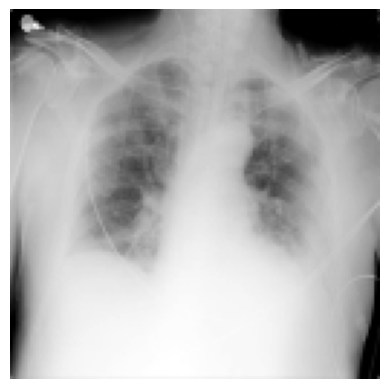

Class,Count
COVID,3616
Lung Opacity,3700
Normal,3700
Viral Pneumonia,1345


In [ ]:
# Create directories if they don't exist
create_directories(resized_folders)

# Function to resize images and save them in the new directories
def resize_and_save_images(image_folder, resized_folder, samples):
    image_files = os.listdir(image_folder)
    image_files = image_files[:samples]  # Select the specified number of samples
    for file_name in image_files:
        img_path = os.path.join(image_folder, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (128, 128))  # Resize the image
        new_file_name = os.path.splitext(file_name)[0] + '_resized.png'  # New file name
        cv2.imwrite(os.path.join(resized_folder, new_file_name), resized_img)

# Resize images and save images
num_samples = [3616, 3700, 3700, 1345]
[resize_and_save_images(clean_folder, resized_folder, samples) for clean_folder, resized_folder, samples in zip(clean_folders, resized_folders, num_samples)]
print("STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.")

Se estandarizan las imágenes después del redimensionamiento

Image dimensions: (128, 128)


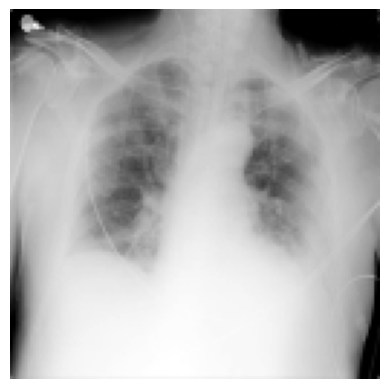

Number of images per class


In [9]:
# Show information
image = cv2.imread(resized_covid_folder+'/COVID-1_resized.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=resized_folders, img=image)
# df

In [ ]:
# Create directories if they don't exist
create_directories(standardized_folders)

# Function to standardize and save images to new directories
def standardize_and_save_images(resized_folder, standardized_folder):
    for filename in os.listdir(resized_folder):
        if filename.endswith('.png'):
            image_path = os.path.join(resized_folder, filename)  # Path to the current image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
            image_float = image.astype("float32")  # Convert the image to a float32 NumPy array
            mean, std_dev = cv2.meanStdDev(image_float)  # Calculate mean and standard deviation
            standardized_mean = 127
            standardized_std_dev = 63
            standardized_image = (image_float - mean) / std_dev * standardized_std_dev + standardized_mean
            standardized_image_uint8 = standardized_image.astype("uint8")  # Convert image to uint8
            new_filename = os.path.splitext(filename)[0] + '_standardized.png'  # New file name
            cv2.imwrite(os.path.join(standardized_folder, new_filename), standardized_image_uint8)  # Save the standardized image

# Standardize and save images
[standardize_and_save_images(resized_folder, standardized_folder) for resized_folder, standardized_folder in zip(resized_folders, standardized_folders)]
print("STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.")

STANDARDIZED IMAGES SAVED IN THE NEW DIRECTORIES.


Image dimensions: (128, 128)


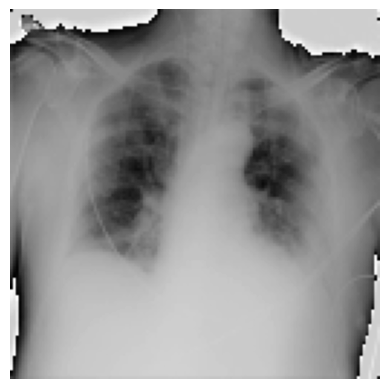

Number of images per class


In [8]:
# Show information
image = cv2.imread(standardized_covid_folder+'/COVID-1_resized_standardized.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=standardized_folders, img=image)
# df

# 3. FEATURE EXTRACTOR

In [327]:
from skimage import feature

# Create directories if they don't exist
create_directories(featured_folders)

# Aplica el extractor de Histogramas de Color
def color_histograms(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    n = sum(hist.flatten())
    hist_normalized = hist.flatten() / n
    return hist_normalized

# Aplica Local Binary Patterns
radius = 1 # Radius of the circle used to calculate the patterns
points = 8 * radius # Number of sampling points on the circle
def local_binary_patterns(image):
    lbp = feature.local_binary_pattern(image, points, radius, method='uniform')
    # lbp_normalized = np.uint8((lbp / np.max(lbp)) * 255)
    lbp_normalized = cv2.normalize(lbp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return lbp_normalized

# Function to standardize and save images to new directories
def apply_feature_extractor(standardized_folder, featured_folder, filter):
    for filename in os.listdir(standardized_folder):
        image_path = os.path.join(standardized_folder, filename)   # Path to the current image        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
        
        # Applies the corresponding extractor according to the type of filter
        if   filter.lower() == "histo" : featured_image = color_histograms(image)
        elif filter.lower() == "lbp"   : featured_image = local_binary_patterns(image)
        else:
            print("Tipo de filtro no válido. Debe ser 'Histo' o 'LBP'.")
            continue
    
        # Save the result as an image in the output directory
        new_filename = os.path.splitext(filename)[0].replace("_resized_standardized", "") + '_featured.png'  # New file name
        cv2.imwrite(os.path.join(featured_folder, new_filename), featured_image) # Save the image

# Standardize and save images
feature_extractor = 'LBP'
[apply_feature_extractor(standardized_folder, featured_folder, filter=feature_extractor) for standardized_folder, featured_folder in zip(standardized_folders, featured_folders)]
print("FEATURED IMAGES SAVED IN THE NEW DIRECTORIES.")

FEATURED IMAGES SAVED IN THE NEW DIRECTORIES.


Image dimensions: (128, 128)


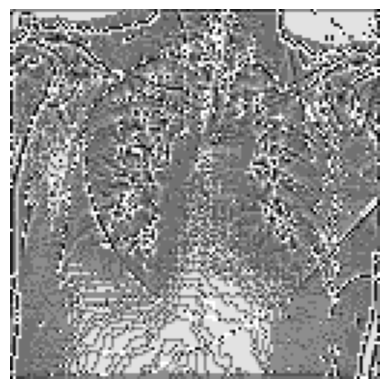

Number of images per class


In [10]:
# Show information
image = cv2.imread(featured_covid_folder+'/COVID-1_featured.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=featured_folders, img=image)
# df

# 4. TRAINING

Load the data of 'X' and 'y'

In [45]:
# Load lung images
covid_data = load_data(featured_covid_folder, 0)
lung_opacity_data = load_data(featured_lung_opacity_folder, 1)
normal_data = load_data(featured_normal_folder, 2)
viral_pneumonia_data = load_data(featured_viral_pneumonia_folder, 3)
data = covid_data + lung_opacity_data + normal_data + viral_pneumonia_data

# Split the list into two separate lists: one for the data and one for the labels
tensor_list  = [item[0] for item in data]
label_list = [item[1] for item in data]

# Combine the data and labels into an unordered list of tuples
combined_list = list(zip(tensor_list, label_list))
random.shuffle(combined_list)

# Separate the combined list into two separate lists again: one for the data and one for the labels
X, y = zip(*combined_list)
X, y = np.array(X), np.array(y)

Split the data into training and test sets

In [69]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the dimensions of the training and test sets
print('Dimension of X_train : ',  X_train.shape)
print('Dimension of X_test  : ',  X_test.shape)
print('Dimension of y_train : ',  y_train.shape)
print('Dimension of y_test  : ',  y_test.shape)

Dimension of X_train :  (9888, 128, 128)
Dimension of X_test  :  (2473, 128, 128)
Dimension of y_train :  (9888,)
Dimension of y_test  :  (2473,)


**Crear y entrenar el modelo MLP utilizando tensorflow**  
El modelo consiste en dos capas ocultas, cada una con una función de activación 'relu' para introducir no linealidad.  
La capa de salida utiliza una función de activación 'sigmoid' ya que estás trabajando en un problema de clasificación binaria.

In [ ]:
import time
from keras.models import Sequential
from keras.layers import Flatten, Dense

# Preprocess the data
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

# Create the MLP model
model = Sequential()
# Flatten the data
model.add(Flatten(input_shape=(X_train.shape[1],)))  
# Add hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Add the output layer
model.add(Dense(1, activation='sigmoid'))
# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train model
start = time.time()
model.fit(X_train, y_train, epochs=1000, batch_size=9000, validation_data=(X_test, y_test), verbose=0)
print("Duration: ", time.time() - start)

Evaluar el modelo

In [66]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

78/78 [==============================] - 0s 6ms/step - loss: -7893198.0000 - accuracy: 0.4808
Loss: -7893198.0
Accuracy: 0.4807925522327423
